# Efficient Transformers

## TLDR

BERT finetuning, knowledge distillation of the fine-tuned BERT model with distilBERT and finally model quantization. <u>Everything using PyTorch</u>.

## About

This is a notebook based on the **Natural Language Processing with Transformers: Building Language Applications with Hugging Face** [[book](https://www.amazon.com/Natural-Language-Processing-Transformers-Applications/dp/1098103246)] chapter 5. My code is based on the ideas presented in the chapter but most is re-written in PyTorch with the exception of the pre-trained models calling and tokenizers, which come from 🤗 HuggingFace.

## The task

The task is to classify a bunch of text prompts comming from a dialog system into 150 different classes from various subjects like "translation", "payday", "time", "flip_coin" etc. The data also contains a special set of text which are labeled as 'oos' meaning "out of sample", which indicate random dialogs which haven't been mapped. So the model needs to attend to this new special case. Therefore, in total, there are 151 different classes. The task can be classified as a single-label multi-class classification problem for which we can only predict one class per instance — i.e. there's no class overlapping like a multi-label task.

## My approach

The chapter of the transformers book starts with a fine-tuned BERT model with a accuracy of 94% for the evaluation set. But I'm proposing an end-to-end approach in which I use a pretrained BERT model to fine-tune it and reach the authors' initial accuracy prior to making the transformations needed to make the model efficient in production.

I wrote my code based on my own knowledge and what I have learned on the last couple of weeks. I focus purelly on PyTorch base classes so for the training part I don't use the `Trainer` API provided by [[🤗 Huggingface](https://huggingface.co/docs/transformers/main_classes/trainer)]. My training process, however, is simple. I didn't apply any special training conditions such as gradient accumulation or callbacks during training.

## Considerations and issues

- *Reproductivity*: Although I filled my code with a huge amount of redundant seed calling, everytime I ran this script I got different results, but spaming between +/- 1% of accuracy or even less.

- *Quantization*: I didn't elaborate much on the final quantization section and I point out the issue with compatibility to GPU and running the benchmarks on GPU against the final quantized model on CPU the GPU latency is far inferior (better).

# Imports

In [1]:
from typing import (Union,
                    Callable,
                    List,
                    Dict,
                    Tuple)
import json
import numpy as np
import pandas as pd
from copy import deepcopy
from transformers import (set_seed,
                          PreTrainedTokenizer,
                          BertTokenizer,
                          BertModel, 
                          DistilBertTokenizer,
                          DistilBertModel)
# Configs
from transformers import (BertConfig, 
                          DistilBertConfig)

from torch.utils.data import (Dataset,
                              DataLoader)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import (Optimizer,
                         Adadelta,
                         AdamW)
from torch.optim.lr_scheduler import StepLR

from sklearn.dummy import DummyClassifier

from tqdm.auto import tqdm
from time import perf_counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook")
sns.set_style("white")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Loading the data

In [3]:
with open("../input/clinc150-dataset/data/data_full.json") as json_file:
    data = json.load(json_file)
print(data.keys())

dict_keys(['oos_val', 'val', 'train', 'oos_test', 'test', 'oos_train'])


In [4]:
def parse_data(data: Dict) -> pd.DataFrame:
    """
    Reconstructs a Pandas DataFrame from the CLINC150 dataset.
    """
    df = pd.DataFrame()
    for k in data.keys():
        split_df = pd.DataFrame(data[k], columns=["text", "intent"])
        split_df.insert(0, "split", k)
        df = pd.concat([df, split_df], axis=0, ignore_index=True)
    return df

df = parse_data(data)
df.head()

,split,text,intent
0,oos_val,set a warning for when my bank account starts ...,oos
1,oos_val,a show on broadway,oos
2,oos_val,who has the best record in the nfl,oos
3,oos_val,how do i find the area of a circle,oos
4,oos_val,how many onions do i have on hand,oos


# Spliting the data

In [5]:
# Split into 'train', 'test'
train_df = df.loc[df["split"].apply(lambda x: x.split("_")[-1]) == "train"].copy(deep=True)
eval_df = df.loc[df["split"].apply(lambda x: x.split("_")[-1]) == "val"].copy(deep=True)
test_df = df.loc[df["split"].apply(lambda x: x.split("_")[-1]) == "test"].copy(deep=True)

print(train_df.shape)
print(eval_df.shape)
print(test_df.shape)

(15100, 3)
(3100, 3)
(5500, 3)


# Encoding the labels

In [6]:
# All classes
classes = train_df["intent"].unique().tolist()
classes[:20]

['translate',
 'transfer',
 'timer',
 'definition',
 'meaning_of_life',
 'insurance_change',
 'find_phone',
 'travel_alert',
 'pto_request',
 'improve_credit_score',
 'fun_fact',
 'change_language',
 'payday',
 'replacement_card_duration',
 'time',
 'application_status',
 'flight_status',
 'flip_coin',
 'change_user_name',
 'where_are_you_from']

In [7]:
# Sorting labels alphabetically and putting 'oos' at last position
classes = [l for l in classes if l != "oos"]

# Remove duplicates (if there're any)
classes_sort = set(sorted(classes) + ["oos"])
classes_sort = list(classes_sort)
classes_sort[-10:]

['how_old_are_you',
 'credit_limit',
 'rewards_balance',
 'pto_balance',
 'what_song',
 'fun_fact',
 'pto_request',
 'pto_used',
 'gas',
 'change_user_name']

In [8]:
# Number of classes
n_classes = len(classes_sort)
print(f"Amount of labels: {n_classes}")

Amount of labels: 151


In [9]:
# Encode classes
class2id = {c: idx for idx, c in enumerate(classes_sort)}
# Print first 10 
{k: v for k, v in class2id.items() if v in list(range(10))}

{'min_payment': 0,
 'order_status': 1,
 'international_fees': 2,
 'uber': 3,
 'direct_deposit': 4,
 'next_holiday': 5,
 'thank_you': 6,
 'ingredient_substitution': 7,
 'calendar_update': 8,
 'oos': 9}

In [10]:
# Encode data
train_df["labels"] = train_df["intent"].map(class2id)
eval_df["labels"] = eval_df["intent"].map(class2id)
test_df["labels"] = test_df["intent"].map(class2id)

# Convert all labels to int
train_df["labels"] = train_df["labels"].astype(int)
eval_df["labels"] = eval_df["labels"].astype(int)
test_df["labels"] = test_df["labels"].astype(int)

# Drop unused columns
train_df.drop(columns=["split", "intent"], inplace=True)
eval_df.drop(columns=["split", "intent"], inplace=True)
test_df.drop(columns=["split", "intent"], inplace=True)

train_df.head()

,text,labels
3100,what expression would i use to say i love you ...,41
3101,can you tell me how to say 'i do not speak muc...,41
3102,"what is the equivalent of, 'life is good' in f...",41
3103,"tell me how to say, 'it is a beautiful morning...",41
3104,"if i were mongolian, how would i say that i am...",41


# Baseline

Let's create a simple baseline model to establish the minimum evaluation accuracy for our dataset. The baseline serves as an indicator of the minimum performance expected from the model.

In [11]:
clf = DummyClassifier()

# Get train/evaluation data
X_train, y_train = train_df["text"].tolist(), train_df["labels"].tolist()
X_eval, y_eval = eval_df["text"].tolist(), eval_df["labels"].tolist()

# Train the classifier
clf.fit(X=X_train, y=y_train)

# Generate predictions and calculate the accuracy
y_preds = clf.predict(X_eval)
baseline_acc = accuracy_score(y_eval, y_preds)
print(f"Baseline accuracy: {baseline_acc:.3f}")

Baseline accuracy: 0.006


# Helper functions

In this section I define some helper functions to fine-tune the model.

- `train_one_epoch`: Train the model for one whole epoch - i.e. pass all training data once through the model and at the end of every training *step* update the model weights.
- `evaluate`:  Evaluate the model performance on the evaluation set. Since it's a classification problem the main performance metric is the accuracy of the model.
- `train`: Basically a wrapper function for the previous ones that controls the whole training process. This function returns the training log with the loss per training epoch. This is a similar approach from the Keras API.
- `plot_train_history`: Plot the train log.

## Train one epoch

In [12]:
def train_one_epoch(model: nn.Module, 
                    dataloader: DataLoader, 
                    criterion: Union[nn.Module, Callable], 
                    optimizer: Optimizer,
                    device: Union[None, str, int]=None, 
                    seed: Union[None, int, str]=None) -> float:
    """
    Train model for one whole epoch and return
    the mean loss per train batch.
    """
    if seed is not None:
        if isinstance(seed, int):
            set_seed(seed)
        else:
            raise TypeError("seed must be an integer.")
            
    if device is not None:
        device = device
    else: # Infer
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    model.train()
    model = model.to(device)
    train_loss = 0
    for batch in tqdm(dataloader, desc="train", leave=False):
        # Zero gradients
        optimizer.zero_grad()
        
        # Send data to device
        inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
        labels = batch["labels"].to(device)
        
        # Run forward pass
        outputs = model(**inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        
        # Calculate gradients
        loss.backward()
        
        # Update weigths
        optimizer.step()
    
    # Return mean loss per batch
    return train_loss/len(dataloader)

## Evaluation

Run the eval data through the Net and compute the logits and the loss. To calculate the accuracy we need to normalize the logits, since their sum won't add to 1 exactly, thus they may not be interpreted as **probabilities** per class. To *normalize* the logits into probabilities we have two main functions: sigmoid and softmax. Check out this cool [[post](https://web.stanford.edu/~nanbhas/blog/sigmoid-softmax/)].
- The sigmoid will squash the logits to a closed interval between [0,1] which indicates if the instance is negative or positive for the provided label. Therefore this function is used for either single-label or multi-label binary classification tasks. The first is easy, if we're trying to predict if someone's sentiment towards a product then we only have one label which may be positive or negative. The later can also be interpreted as a multi-class multi-label classification which has more than one single label, sentiment and quality for example and they aren't multually exclusive, someone might have a positive feeling towards the product but may classify its material as a bad-quality. So basically each label has its own little box that doesn't care about the other ones.

- The softmax will also squash the logits to the same closed interval between [0,1], but now the difference is that it returns a probabilities distribution for each class for a label. Therefore we're talking about a single-label multi-class classification problem, for which we only have one label but it may assume one specific value amongst a list of possibilities. This is the one to go based on our data for which we have to classify the specific intent from a list of possibilities.

In [13]:
def evaluate(model: nn.Module, 
             dataloader: DataLoader,
             criterion: Union[nn.Module, Callable],
             device: Union[None, int, str]=None) -> Tuple:
    """
    Run an evaluation pass and return the mean loss
    per evaluation batch and total accuracy.
    """
    if device is not None:
        device = device
    else: # Infer
        device = "cuda" if torch.cuda.is_available() else "cpu"
        
    # Freeze dropout layer
    model.eval()
    model = model.to(device)
    eval_loss = 0
    true_labels, all_preds = [], []
    
    for batch in tqdm(dataloader, desc="eval", leave=False):
        inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
        labels = batch["labels"].to(device)
        
        # Run forward pass without tracking grads
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Calculate loss
        eval_loss += criterion(outputs, labels).item()
        
        # Apply Softmax to normalize multi-class logits to predictions
        probs = F.softmax(outputs, dim=-1)
        preds = torch.argmax(probs, dim=-1)
        
        # Store data to calculate accuracy
        all_preds.extend(preds.tolist())
        true_labels.extend(labels.tolist())
    
    # Calculate accuracy
    eval_acc = accuracy_score(true_labels, all_preds)
    # Return mean loss per batch
    return (eval_loss/len(dataloader), eval_acc)

## Train wrapper

In [14]:
def train(model: nn.Module, 
          train_loader: DataLoader, 
          eval_loader: DataLoader,
          criterion: Union[nn.Module, Callable],
          optimizer: Optimizer,
          n_epochs: int=1,
          scheduler: Union[None, Optimizer]=None,
          device: Union[None, str, int]=None,
          seed: Union[None, int, str]=None) -> Dict[str, List[float]]:
    """
    Train the model for n_epochs and evaluate on the
    evaluation set and returns the training history dict.
    
    The training saves the model's state_dict after every
    epoch and at the end loads the best one.
    """
    if seed is not None:
        if isinstance(seed, int):
            set_seed(seed)
        else:
            raise TypeError("seed must be an integer.")
            
    if device is not None:
        device = device
    else: # Infer
        device = "cuda" if torch.cuda.is_available() else "cpu"
        
    # History
    history = {"train_loss": [], "eval_loss": [], "eval_acc": []}
    
    # Save best model
    best_acc = 0
    best_checkpoint = dict()
        
    for epoch in tqdm(range(1, n_epochs + 1), desc="train"): 
        # Train one epoch and calculate the train time in seconds
        start_time = perf_counter()
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device, seed)
        end_time = perf_counter()
        elapsed_time = end_time - start_time
        
        # Adjust lr
        if scheduler is not None:
            scheduler.step()

        # Run evaluation
        eval_loss, eval_acc = evaluate(model, eval_loader, criterion, device)
        
        # Save best model
        is_best = eval_acc > best_acc
        if is_best:
            # Save model's state_dict
            model.eval() # Freeze dropout
            best_checkpoint["state_dict"] = deepcopy(model.state_dict())
            # Update best eval accuracy
            best_acc = eval_acc
            
        # Updated history
        history["train_loss"].append(train_loss)
        history["eval_loss"].append(eval_loss)
        history["eval_acc"].append(eval_acc)
        
        # Report
        print(f"Epoch {epoch}: Train Loss {train_loss:.3f} - Eval Loss {eval_loss:.3f} - Eval Acc {eval_acc:.3f} - Train Time {elapsed_time:,.1f}")
        
    print("Loading best checkpoint...")
    model = model.load_state_dict(best_checkpoint["state_dict"])
    
    return history

## Plot losses

Helper functions to plot the training log.

In [15]:
def plot_train_history(history: Dict[str, List[float]]) -> None:
    """
    Plot train and evaluation loss and evaluation accuracy.
    """
    fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
    train_loss = np.array(history["train_loss"])
    eval_loss = np.array(history["eval_loss"])
    eval_acc = np.array(history["eval_acc"])
    epochs = np.arange(1, len(train_loss) + 1, 1, dtype=int)
    
    # Plot loss
    sns.lineplot(x=epochs, y=train_loss, label="train loss", ax=axes[0])
    sns.lineplot(x=epochs, y=eval_loss, label="eval loss", ax=axes[0])
    axes[0].set_title("Train and Evaluation Loss")
    axes[0].set_ylabel("Loss")
    axes[0].set_xlabel("epochs")
    
    # Plot accuracy
    sns.lineplot(x=epochs, y=eval_acc, label="eval accuracy", ax=axes[1])
    axes[1].set_title("Evaluation Accuracy")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_xlabel("epochs")
    fig.tight_layout()
    plt.show()

## Other helpful functions

In [16]:
def get_num_parameters(model: nn.Module, count_nonzero_only: bool=False) -> int:
    """
    Calculate the number of parameters of the model.
    If count_nonzero_only is True, count only nonzero weights.
    """
    num_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_elements += param.count_nonzero()
        else:
            num_elements += param.numel()
    return num_elements

# Fine-tune BERT Base

In this section I create a wrapper class to hold the pretrained BERT model and add on top of it a classification head which is composed by a dropout layer followed by a linear layer to convert the encoded squences into logits for the 151 different classes. Later these logits can be normalized into probabilities by a softmax function which we finally pass through a cross entropy loss function to get the loss, calculate the gradients and update the network's weights. This also include the fine-tuned BERT's weights.

## Load bert-uncased checkpoint

In [17]:
checkpoint = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(checkpoint)
bert_model = BertModel.from_pretrained(checkpoint).to(device)

In [18]:
n_params = get_num_parameters(bert_model)
print(f"BERT Model has {n_params:,} parameters.")

BERT Model has 109,482,240 parameters.


## Add a classification head to BERT

Adding a linear final layer to BERT's outputs to squeeze the context information into a multilabel output. Note: Although this is a multiclass single label problem, I'm using cross entropy as loss function which expects a probability for each class per sequence.

In [19]:
class BERTForClassification(nn.Module):
    """
    BERT model with classification head.
    
    This class extends a BERT model with a custom classification head,
    allowing it to be fine-tuned for classification tasks.
    The `pretrainedModel` is a pre-trained BERT model, and `n_labels`
    specifies the number of distinct labels for classification.

    Parameters:
        pretrainedModel (BertModel): A pre-trained BERT model.
        n_labels (int): The number of distinct labels for classification.
    """
    def __init__(self, 
                 pretrainedModel: BertModel,
                 n_labels: int):
        super(BERTForClassification, self).__init__()
        self.config = pretrainedModel.config
        self.hidden_size = self.config.hidden_size
        self.n_labels = n_labels
        
        # Pretrained BERT
        self.bert = pretrainedModel
        
        # Get config dropout rate
        if self.config.classifier_dropout is not None:
            classifier_dropout = self.config.classifier_dropout
        elif self.config.hidden_dropout_prob is not None:
            classifier_dropout = self.config.hidden_dropout_prob
        else:
            classifier_dropout = 0.1

        # Linear head (dropout + linear layer)
        self.dropout = nn.Dropout(classifier_dropout)
        self.linear = nn.Linear(self.hidden_size, self.n_labels)
        
    
    def forward(self, **kwargs):
        """
        Perform a forward pass for the BERT model with the classification head.

        Parameters:
            **kwargs: Keyword arguments to pass to the BERT model.
                May include the following keys 'input_ids', 'attention_mask' and
                'token_type_ids' in case of pretrained BERT.

        Returns:
            torch.Tensor: The output tensor after passing through the classification head.
        """
        outputs = self.bert(**kwargs).get("pooler_output")
        outputs = self.dropout(outputs)
        outputs = self.linear(outputs)
        return outputs

## Create datasets and dataloaders

Pytorch's `Dataset` and `DataLoader` classes provide a robust way to handle and process data for deep learning tasks using Pytorch classes. 

"Ideally we want our dataset code to be decoupled from our model training code for better readability and modularity." — [PyTorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#:~:text=Dataset%20stores%20the%20samples%20and,easy%20access%20to%20the%20samples.)

So we create a class to instantiate an object to hold our preprocessed data and a loader to iteratively draw samples either shuffled or not, with a predefined batch size and other customizable features. But the main point is that we have an abstract pipeline to extract data that prevents overwriting and provides parallel processing and memory management that is adjustable.

In [20]:
class ClincDataset(Dataset):
    """
    A custom PyTorch dataset for the Clinc Intent Classification task.

    Args:
        text (List[str]): List of text samples.
        labels (List[int]): List of corresponding labels.
    """
    def __init__(self, 
                 text: List[str],
                 labels: List[int]):
        self.text = text
        self.labels = labels
        
    
    def __len__(self):
        return len(self.text)
    
    
    def __getitem__(self, idx):
        return self.text[idx], self.labels[idx]
    
train_set = ClincDataset(*zip(*train_df.values.tolist()))
eval_set = ClincDataset(*zip(*eval_df.values.tolist()))
test_set = ClincDataset(*zip(*test_df.values.tolist()))

train_set[:2]

(('what expression would i use to say i love you if i were an italian',
  "can you tell me how to say 'i do not speak much spanish', in spanish"),
 (41, 41))

## Data Collator

Later in the code, I plan to test other model architectures that may not use the same tokenizer as the bert-base model. To avoid the need to rewrite the customized collate function `collate_fn`, we can simply utilize a **closure**, which is a function with a self-contained function that can be customized based on the provided arguments—in this case, the tokenizer. Every time we call `create_collate_fn` while specifying the tokenizer, it returns a collate function that uses the provided tokenizer to create the model inputs. This approach eliminates the necessity to rewrite the dataset class for every new architecture. Instead, we only need to create a collate function with the appropriate tokenizer and pass it to the `DataLoader` in order to create a tailored DataLoader for the specific model.

In [21]:
def create_collate_fn(tokenizer: PreTrainedTokenizer) -> Callable:
    """
    Returns a collate function that utilizes the provided tokenizer.
    
    Parameters:
        tokenizer (PreTrainedTokenizer): The tokenizer to be used.
    
    Returns:
        Callable: The custom collate function.
    """
    def collate_fn(inputs: List[Tuple]) -> Dict[str, torch.tensor]:
        """
        Custom collate function to tokenize and pad inputs and return labels.
        
        Parameters:
            inputs (List[Tuple]): A list of input text and labels.
            
        Returns:
            Dict[str, torch.Tensor]: A dictionary containing tokenized and 
                padded inputs with labels.
        """
        # Unpack text and labels
        text, labels = zip(*inputs)
        # Create input_ids, token_type_ids and attention_mask
        inputs = tokenizer(text, 
                           truncation=True,
                           padding=True,
                           max_length=128,
                           return_tensors="pt")

        # Create labels tensor
        labels = torch.tensor(labels)
        # Insert labels
        inputs.update({"labels": labels})
        return inputs
    return collate_fn

collate_fn = create_collate_fn(tokenizer)

In [22]:
# Set seed for reproductivity
set_seed(123)

# Create dataloaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
eval_loader = DataLoader(eval_set, batch_size=32, shuffle=False, collate_fn=collate_fn)

## Fine-tune model

Some comments:

- **Loss reduction**: Initially, I aimed for `reduction="sum"` for cross-entropy loss to return the average loss per training/evaluation instance by dividing the accumulated (summed) loss by the number of training/evaluation rows. However, I later discovered that this approach had a disadvantage, as highlighted in a PyTorch [[discussion](https://discuss.pytorch.org/t/loss-reduction-sum-vs-mean-when-to-use-each/115641)] where one of the library maintainers pointed out that summing all instances across batches before calculating gradients would scale the loss relative to the batch size, which might not be the same for the last batch. To address this issue, we could scale the learning rate according to the batch size, but this would introduce unnecessary training complexity. Consequently, I have opted to use the 'default' setting for cross-entropy, which is `reduction="mean"`. This setting involves summing all batch losses and dividing them by the DataLoader size (total batches), resulting in a 'mean loss per batch,' which should be sufficient for tracking during training.

In [23]:
# Create model
model = BERTForClassification(bert_model, n_classes)

# Training args
n_epochs = 2 # 8
lr = 3e-5 # learning rate
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=.9) # Reduces 10% of the initial lr

# Train the model
history = train(model,
                train_loader,
                eval_loader,
                criterion=criterion,
                optimizer=optimizer,
                n_epochs=n_epochs,
                scheduler=scheduler,
                device=device,
                seed=123)

train:   0%|          | 0/2 [00:00<?, ?it/s]

train:   0%|          | 0/472 [00:00<?, ?it/s]

eval:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 1: Train Loss 3.417 - Eval Loss 1.665 - Eval Acc 0.867 - Train Time 41.9


train:   0%|          | 0/472 [00:00<?, ?it/s]

eval:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 2: Train Loss 0.903 - Eval Loss 0.580 - Eval Acc 0.925 - Train Time 40.0
Loading best checkpoint...


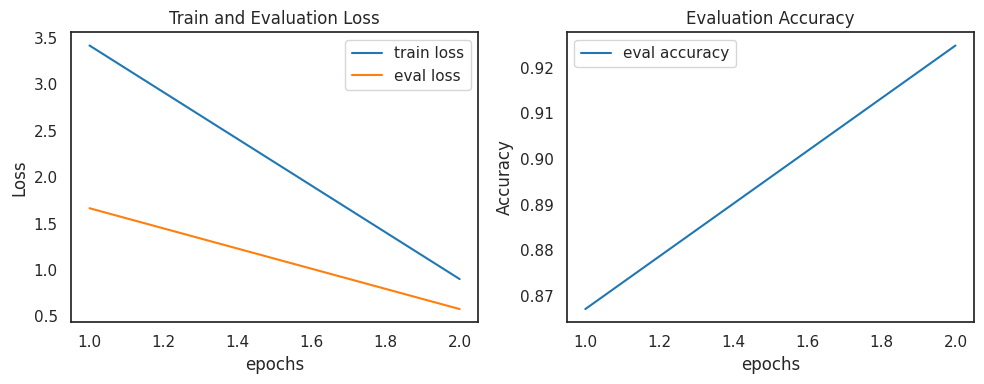

In [24]:
plot_train_history(history)

# Benchmarking

To keep track of the fine-tuned models' performance let's create a class with all tests we will be running to measure the models' performance like recovering the accuracy, computing its size and last but not least the latency.

In [25]:
class PerformanceBenchmark:
    """
    Create a performance benchmark for a fine-tuned BERT model and measure various performance metrics.

    This class allows you to evaluate the performance of a fine-tuned BERT model, including:
    - Accuracy of the model using the evaluation set.
    - Size of the model in MiB.
    - Latency of the model in ms.

    Parameters:
        tokenizer (PreTrainedTokenizer): The tokenizer to convert text into tensors.
        model (nn.Module): The fine-tuned model.
        eval_loader (DataLoader): The evaluation DataLoader.
        name (str): The benchmark name.
        device (Union[int, str, None], optional): The device for benchmarking (e.g., 'cuda', 'cpu').
            Default is 'cuda' if available.

    Methods:
        evaluate(): Run evaluation on the eval_loader DataLoader and compute the accuracy for the model.
        compute_size(): Get model size in MiB.
        compute_latency(): Compute mean and standard deviation of latency in ms.
        run_benchmark(): Run all tests and return a dictionary with results.
        compare_benchmarks(*args): Return a Pandas DataFrame with benchmark comparisons.

    The performance benchmark class is designed to measure various aspects of a fine-tuned BERT model's performance.
    """
    def __init__(self, 
                 tokenizer: PreTrainedTokenizer,
                 model: nn.Module,
                 eval_loader: DataLoader, 
                 name: str, 
                 device: Union[int, str, None]=None):
        self.tokenizer = tokenizer
        self.model = model
        self.eval_loader = eval_loader
        self.name = name
        if device is None:
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
        else:
            self.device = device

        
    def evaluate(self) -> float:
        """
        Run evaluation on the eval_loader DataLoader and compute the accuracy for the model.

        Returns:
            float: The accuracy of the model.
        """
        _, eval_acc = evaluate(model=self.model, 
                               dataloader=self.eval_loader,
                               criterion=nn.CrossEntropyLoss(), # Just to run the function
                               device=self.device)
        return np.round(eval_acc, decimals=3)
    
    
    def compute_size(self) -> float:
        """
        Get model size in MiB.

        Returns:
            float: The model size in MiB.
        """
        param_size, buffer_size = 0, 0
        for param in self.model.parameters():
            param_size += param.nelement() * param.element_size()
        for buffer in self.model.buffers():
            buffer_size += buffer.nelement() * buffer.element_size()
        # Compute total size in MiB
        model_size = (param_size + buffer_size) / (1024**2) # B -> MiB
        return np.round(model_size, decimals=3)
    
    
    def compute_latency(self) -> Tuple[float, float]:
        """
        Compute mean and std latency in ms.

        Returns:
            Tuple[float, float]: The mean and standard deviation of latency in ms.
        """
        sample = "what is the equivalent of, 'life is good' in french"
        tokens = self.tokenizer(sample, return_tensors="pt").to(self.device)
        # Send model to proper device
        self.model.to(self.device)
        # Warmup
        for _ in range(10):
            _ = self.model(**tokens)
        # Timed run
        latencies = []
        for _ in range(100):
            start_time = perf_counter()
            _ = self.model(**tokens)
            end_time = perf_counter()
            latency = end_time - start_time # S
            latencies.append(latency)
        mean_latency = np.mean(latencies) * 1000 # ms
        std_latency = np.std(latencies) * 1000 # ms
        return (np.round(mean_latency, decimals=3),
                np.round(std_latency, decimals=4))
    
    
    def run_benchmark(self) -> Dict:
        """
        Run all tests and return a dictionary with results.
        
        Returns:
            Dict: A dictionary containing benchmark results.
        """
        mean_latency, std_latency = self.compute_latency()
        results = {
            "size": self.compute_size(),
            "mean_latency": mean_latency,
            "std_latency": std_latency,
            "accuracy": self.evaluate()
        }
        return results
            
    
    @staticmethod
    def compare_benchmarks(*args) -> pd.DataFrame:
        """
        Return a Pandas DataFrame with all benchmarks.
        
        Parameters
            *args (PerformanceBenchmark): List or tuple with benchmarks to be compared.
                
        Returns
            pd.DataFrame: Pandas DataFrame with the tests comparisson.
        """
        if not any(isinstance(bench, PerformanceBenchmark) for bench in args):
            raise TypeError("All arguments must be 'PerformanceBenchmark' instances.")
            
        data = pd.DataFrame()
        for bench in args:
            results = {"name": bench.name}
            results.update(bench.run_benchmark())
            results = {k: [v] for k, v in results.items()}
            data = pd.concat([data, pd.DataFrame(results)], axis=0, ignore_index=True)
        return data

In [26]:
# Creating the benchmark for the current fine-tuned model
benchmark1 = PerformanceBenchmark(tokenizer, model, eval_loader, "bert fine-tune")
PerformanceBenchmark.compare_benchmarks(benchmark1)

eval:   0%|          | 0/97 [00:00<?, ?it/s]

,name,size,mean_latency,std_latency,accuracy
0,bert fine-tune,418.092,9.972,0.2887,0.925


# Trying a smaller architecture

Since we got a nice evaluation accuracy we have a decent indicator of how well a fine-tuned BERT may perform. So we can test with more performant architectures - i.e. smaller - and see if the same performance is obtained and with a reduced latency and overall computational expenditure.

## Load Distilled BERT uncased checkpoint

In [27]:
distilbert_checkpoint = "distilbert-base-uncased"
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(distilbert_checkpoint)
distilbert_model = DistilBertModel.from_pretrained(distilbert_checkpoint).to(device)

## Add classification head to distilBERT

Vanilla BERT returns both last_hidden_state and pooler_output. The first one has the representation for every token in each sequence and the first token represents the [CLS] token which has the representation for the whole sequence. So this tensor has an extra dimension and size of (batch_size, seq_length, hidden_size). On the other hand, pooler_output contains the representation of each sequence of the batch which comes from extracting the [CLS] token representation from the last_hidden_state and passing it through the BertPooler layer. This layer is a feedforward pretrained linear layer with tanh activation function [Reference]. So this tensor has shape of (batch_size, hidden_size). 

DistilBERT on the other hand only produces `last_hidden_state`, so to get the representation for the whole sequence one may draw the first token for each batch and run it through a linear layer followed by a ReLU activation function according to the original code [[DistilBertForSequenceClassification](https://github.com/huggingface/transformers/blob/v4.34.1/src/transformers/models/distilbert/modeling_distilbert.py#L730)].

In [28]:
class DistilBERTForClassification(nn.Module):
    """
    DistilBERT model fine-tuned for classification tasks.

    Parameters:
        pretrainedModel (DistilBERT): Pre-trained distilBert model.
        n_labels (int): The number of distinct labels for classification.
    """
    def __init__(self, 
                 pretrainedModel: BertModel,
                 n_labels: int):
        super(DistilBERTForClassification, self).__init__()
        self.config = pretrainedModel.config
        self.hidden_size = self.config.hidden_size
        self.n_labels = n_labels
        
        # Pretrained distilBERT
        self.distilbert = pretrainedModel
        
        # Get config dropout rate
        if self.config.seq_classif_dropout is not None:
            classifier_dropout = self.config.seq_classif_dropout
        else:
            classifier_dropout = 0.1

        # Pre-classification head
        self.pre_classifier = nn.Linear(self.hidden_size, self.hidden_size)
        
        # Classifier head (dropout + linear layer)
        self.dropout = nn.Dropout(classifier_dropout)
        self.linear = nn.Linear(self.hidden_size, self.n_labels)
        
    
    def forward(self, **kwargs):
        """
        Perform a forward pass for the DistilBERT model with the classification head.

        Parameters:
            **kwargs: Keyword arguments to pass to the DistilBERT model. 
                May include the following keys: 'input_ids' and 'attention_mask'.

        Returns:
            torch.Tensor: The output tensor after passing through the classification head.
        """
        outputs = self.distilbert(**kwargs).get("last_hidden_state")[:, 0, :]
        
        # Pre classification
        outputs = self.pre_classifier(outputs)
        outputs = nn.ReLU()(outputs)
        
        # Classifier
        outputs = self.dropout(outputs)
        outputs = self.linear(outputs)
        return outputs

In [29]:
# Model for sequence classification
distil_model = DistilBERTForClassification(distilbert_model, n_classes).to(device)

In [30]:
distil_nparams = get_num_parameters(distil_model)
print(f"Distilled Bert has {distil_nparams:,} parameters.")

Distilled Bert has 67,069,591 parameters.


## Create a new data collator and dataloader

In [31]:
# Set seed for reproductivity
set_seed(123)

# New data collator
distil_collate_fn = create_collate_fn(distilbert_tokenizer)

# New train and eval loaders

# Create dataloaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=distil_collate_fn)
eval_loader = DataLoader(eval_set, batch_size=32, shuffle=False, collate_fn=distil_collate_fn)

## Fine-tune distilBERT

In [32]:
# Training args
n_epochs = 2
lr = 3e-5 # learning rate
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(distil_model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=.9) # Reduces 10% of the initial lr

# Train the model
history = train(distil_model,
                train_loader,
                eval_loader,
                criterion=criterion,
                optimizer=optimizer,
                n_epochs=n_epochs,
                scheduler=scheduler,
                device=device,
                seed=123)

train:   0%|          | 0/2 [00:00<?, ?it/s]

train:   0%|          | 0/472 [00:00<?, ?it/s]

eval:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 1: Train Loss 3.052 - Eval Loss 1.100 - Eval Acc 0.875 - Train Time 21.3


train:   0%|          | 0/472 [00:00<?, ?it/s]

eval:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 2: Train Loss 0.501 - Eval Loss 0.380 - Eval Acc 0.932 - Train Time 21.3
Loading best checkpoint...


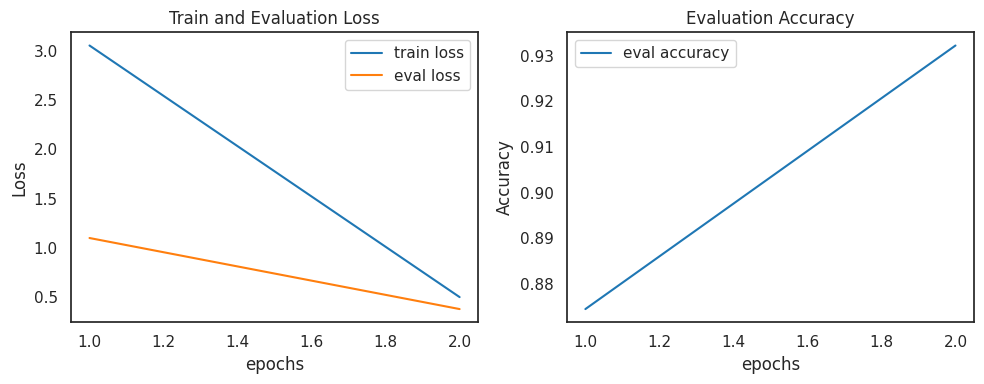

In [33]:
# Plot train history
plot_train_history(history)

In [34]:
# Check distilBert performance
benchmark2 = PerformanceBenchmark(distilbert_tokenizer,
                                  distil_model,
                                  eval_loader,
                                  "distilbert fine-tune")
PerformanceBenchmark.compare_benchmarks(benchmark1, benchmark2)

eval:   0%|          | 0/97 [00:00<?, ?it/s]

eval:   0%|          | 0/97 [00:00<?, ?it/s]

,name,size,mean_latency,std_latency,accuracy
0,bert fine-tune,418.092,10.205,1.0136,0.925
1,distilbert fine-tune,255.854,5.465,0.2554,0.932


# Organizing benchmarks

Just creating a list to store all benchmark object for easy calling of the `compare_benchmarks` method.

In [35]:
# All benchmarks
all_benchmarks = [benchmark1, benchmark2]

# Knowledge distillation

We got an even better evaluation accuracy and 2x reduced latency fine-tunning the data using distilBERT. So far this model should be fine to be evaluated using the held-out test set and se if it's good to go to be deployed. If, of course there's no need for a super accuracy rate like 99ish.
But the purpose of this notebook is to try efficient techniques to minimize the model's latency while keeping the accuracy score high. So now let's pretend the distilBert didn't perform as well. Now its accuracy is just 80.0%. Perhaps the smaller model didn't have enough parameters to catch the data nuances. So one way to help the smaller model would be using a technique called ***knowledge distillation**** which consitsts basically on using the orignal model's logits <u>after have been fine-tuned</u> together with the smaller model's logits to calculate a loss which has two portions: 

- The first part is the small model's vanilla cross entropy loss, which is multiplied by a weightening factor **alpha** $(\alpha)$ that controls if the major portion of the compound loss mainly comes from the vanilla cros entropy loss of the small model. 

- The second part of the loss is a probabilities distribution comparrison using Kullback-Leibler divergence between the small and the original models. To obtain the probability distributions for both models we simply take their logits and apply a softmax function which would normalize them to probabilities [[Reference](https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow)]. But before applying the softmax function, we divide the logits by a factor called **temperature** $(T)$. This factor controls the probability distribution for the outputs' labels and the default value is 1.0 which falls back to the vanilla softmax function. When we increase the temperature, i.e. place a number higher than 1.0, we smoothen the probability distribution curve giving more weight to less probable classes. On Geoffrey Hinton's [[article](https://arxiv.org/pdf/1503.02531)] on knowledge distillation, he states that much of the learned *generalization capability* of the model resides in the ratios of small probabilities in the distribution. Therefore the distillation training would benefit from an increase of the temperature factor. The probabilities are used to calculate the divergence which is multiplied by the squared temperature to scale back the results. The loss result is multiplied by $(1 - \alpha)$ to control the weight of the final loss.
$$
P = Softmax(logits/T)
$$

$$
Loss = \alpha*CE_{Loss} + (1 - \alpha)*KD_{Loss}
$$

## Creating the custom loss function

Note: Smaller model and Student model are interchangeable as well as Original model and Teacher model.

In [36]:
class DistillationLoss(nn.Module):
    def __init__(self, 
                 temperature: float=2.0,
                 alpha: float=0.5):
        """
        Calculates the distillation loss for knowledge transfer from a teacher model to a student model.
        
        The loss consists of a combination of student's cross-entropy loss and Kullback-Leibler divergence loss
        between the student and teacher probability distributions. 
        
        The trade-off between these losses is controlled by the 'alpha' parameter. The final loss is 
        averaged by the number of data points in 'student_logits' for scaling.
        
        temperature (float, optional): The temperature parameter for distillation (default is 2.0).
        alpha (float, optional): The weighting factor for the trade-off between student and teacher losses (default is 0.5).
            Must be in the range [0.0, 1.0].
        """
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        # Normalizes the alpha between 0.0 and 1.0
        self.alpha = max(0.0, min(1.0, alpha))
        
    
    def forward(self, 
                student_logits: torch.tensor,
                teacher_logits: torch.tensor,
                labels: torch.tensor) -> torch.tensor:
        """
        Compute the distillation loss based on the student's and teacher's logits.
        
        Parameters:
            student_logits (torch.tensor): Logits produced by the student model.
            teacher_logits (torch.tensor): Logits produced by the teacher model.
            labels (torch.tensor): True labels.
            
        Returns:
            torch.tensor: The computed distillation loss.
        """
        # Calculate probabilities
        student_probs = F.softmax(student_logits/self.temperature, dim=-1)
        teacher_probs = F.softmax(teacher_logits/self.temperature, dim=-1)

        # Calculate student's cross entropy loss
        student_loss = nn.CrossEntropyLoss(reduction="mean")(student_logits, labels)

        # Calculate Kullback-Leibler loss between the teacher and student
        kl_loss = nn.KLDivLoss(reduction="batchmean", log_target=True)
        teacher_loss = (self.temperature**2) * kl_loss(student_probs, teacher_probs)

        # Calculate combined loss
        combined_loss = (self.alpha * student_loss) + ((1 - self.alpha) * teacher_loss)

        # Return mean loss
        return combined_loss

## Reconstructing the DataLoaders

We also need to adapt the current training function to generate the teacher's logits and feed them into the custom distillation loss function to calculate the gradients for adjusting the student's weights.

Key considerations include:

- **Preprocessing**: We cannot assume that both the student and teacher tokenizers are the same. To address this, we can add two new arguments to the training function: `student_collate_fn` and `teacher_collate_fn`. If we haven't tokenized the training and evaluation datasets beforehand, we can apply both data collators to tokenize the data on-the-fly.

- **Shuffle**: Up until now, we have been using pre-built DataLoaders in the training function with the `shuffle=True` argument. However, even with the same seed, it's crucial to ensure that the input data for both the student and teacher models remains consistent. Unfortunately, there's no direct solution for iterating through two DataLoaders with the `shuffle` parameter set to True. This [[discussion](https://discuss.pytorch.org/t/how-to-set-two-dataloaders-of-the-same-dataset-to-the-same-shuffle/42558/3)] in the official PyTorch forum tries to address this issue, but with no definitive solution. To address this, we can create a helper function to be called at the beginning of every training epoch, which shuffles the dataset before creating the DataLoader.

In [37]:
def create_dataloaders(dataset: Dataset,
                       batch_size: int=1,
                       student_collate_fn: Callable=None,
                       teacher_collate_fn: Callable=None,
                       shuffle: bool=True,
                       seed: int=None) -> Tuple[DataLoader, DataLoader]:
    """
    Create data loaders for the student and teacher models.
    
    Parameters:
        dataset (Dataset): The dataset to create data loaders from.
        batch_size (int, optional): The batch size for the data loaders (default is 1).
        student_collate_fn (Callable, optional): A function to collate student model batches.
        teacher_collate_fn (Callable, optional): A function to collate teacher model batches.
        shuffle (bool, optional): Whether to shuffle the data (default is True).
        seed (int, optional): Seed for randomization (default is None).
        
    Returns:
        Tuple[DataLoader, DataLoader]: A tuple containing the data loaders for
            the student and teacher models.
    """
    if seed is not None:
        if isinstance(seed, int):
            set_seed(seed)
        else:
            raise TypeError("seed must be an integer.")
            
    # Create shuffled indices
    indices = list(range(0, len(dataset)))
    if shuffle:
        indices = np.random.choice(indices,
                                   size=len(indices),
                                   replace=False)
    
    # Create DataLoaders
    student_loader = DataLoader([dataset[idx] for idx in indices],
                                batch_size=batch_size,
                                shuffle=False,
                                collate_fn=student_collate_fn)
    teacher_loader = DataLoader([dataset[idx] for idx in indices],
                                batch_size=batch_size,
                                shuffle=False,
                                collate_fn=teacher_collate_fn)
    return student_loader, teacher_loader

## New training functions

We need to adapt the training process to account for the two models and the new loss function. Now we have to use batch's data to generate the teacher model's logits and the student model's logits to calculate the custom loss. During inference time we only use the teacher's logits to calculate the evaluation loss for comparability to the training loss. But we also compute the accuracy based only on the student's loss, which would emulate a more on production stage in which we wouldn't be using the teacher model alongside the student model, since the whole purpose was to only use the student model to reduce size and latency.

### Epoch training

In [38]:
def train_one_epoch_student(student_model: nn.Module,
                            teacher_model: nn.Module, 
                            student_loader: DataLoader, 
                            teacher_loader: DataLoader, 
                            criterion: nn.Module, 
                            optimizer: Optimizer, 
                            device: Union[int, str, None]=None, 
                            seed: Union[int, None]=None) -> float:
    """
    Trains the student model with soft probabilities of the teacher model.
    
    Parameters:
        student_model (nn.Module): The student model to be trained.
        teacher_model (nn.Module): The teacher model for knowledge distillation.
        student_loader (DataLoader): DataLoader for the student model.
        teacher_loader (DataLoader): DataLoader for the teacher model..
        criterion (nn.Module): The custom distillation loss function.
        optimizer (Optimizer): The optimizer used for training.
        device (Union[int, str, None], optional): The device on which to perform training (default is None).

    Returns:
        float: The mean train loss per batch.
    """
    if seed is not None:
        if isinstance(seed, int):
            set_seed(seed)
        else:
            raise TypeError("seed must be an integer.")
            
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    else:
        device = device
            
    student_model.train()
    teacher_model.eval()
    train_loss = 0
    
    # zip is meant to handle iterables with different lenghts, therefore tqdm
    # won't know the 'total' length so we need to specify it.
    for student_batch, teacher_batch in tqdm(zip(student_loader, teacher_loader),
                                             total=len(student_loader),
                                             desc="train", 
                                             leave=False):
        # Zero student gradients
        optimizer.zero_grad()
        
        # Send data to device
        student_inputs = {k: v.to(device) for k, v in student_batch.items() if k != "labels"}
        labels = student_batch["labels"].to(device)
        
        # No need for teacher labels
        teacher_inputs = {k: v.to(device) for k, v in teacher_batch.items() if k != "labels"}
        
        # Compute teacher logits without tracking gradients
        with torch.no_grad():
            teacher_logits = teacher_model(**teacher_inputs)
            
        # Compute student logits
        student_logits = student_model(**student_inputs)
        
        # Compute loss
        loss = criterion(student_logits, teacher_logits, labels)
        train_loss += loss.item()
        
        # Calculate gradients
        loss.backward()
        
        # Adjust weights
        optimizer.step()
        
    # mean loss per batch
    return train_loss/len(student_loader)

### Student evaluation

In [39]:
def evaluate_student(student_model: nn.Module,
                     teacher_model: nn.Module,
                     student_loader: DataLoader,
                     teacher_loader: DataLoader, 
                     criterion: nn.Module,
                     device: Union[int, str, None]=None) -> Tuple[float, float]:
    """
    Evaluate the student model's performance by comparing it to the teacher model on a given dataset.
    Return a tuple with evaluation loss and accuracy. The later is based on the most probable
    class predicted by the student model after applying Softmax to its logits.

    Args:
        student_model (nn.Module): The student model to be evaluated.
        teacher_model (nn.Module): The teacher model for reference in knowledge distillation.
        student_loader (DataLoader): DataLoader for the student model.
        teacher_loader (DataLoader): DataLoader for the teacher model.
        criterion (nn.Module): The loss function used for evaluation.
        device (Union[int, str, None], optional): Device for evaluation (e.g., 'cuda', 'cpu'). Default is None.

    Returns:
        Tuple[float, float]: A tuple containing the evaluation loss and accuracy.
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    else:
        device = device
    
    # Set models to evaluation mode
    student_model.eval()
    teacher_model.eval()
    
    # Store loss, labels and predictions
    eval_loss = 0
    true_labels, all_preds = [], []
    
    for student_batch, teacher_batch in tqdm(zip(student_loader, teacher_loader),
                                             total=len(student_loader),
                                             desc="eval", 
                                             leave=False):
        # Send data to device
        student_inputs = {k: v.to(device) for k, v in student_batch.items() if k != "labels"}
        labels = student_batch["labels"].to(device)
        
        # No need for teacher labels
        teacher_inputs = {k: v.to(device) for k, v in teacher_batch.items() if k != "labels"}
        
        # Run forward pass without tracking grads
        with torch.no_grad():
            student_logits = student_model(**student_inputs)
            teacher_logits = teacher_model(**teacher_inputs)
        
        # Calculate loss
        eval_loss += criterion(student_logits, teacher_logits, labels).item()
        
        # Apply Softmax to normalize multi-class logits to predictions
        probs = F.softmax(student_logits, dim=-1)
        
        # Select the most probable class
        preds = torch.argmax(probs, dim=-1)
        
        # Store data to calculate accuracy
        all_preds.extend(preds.tolist())
        true_labels.extend(labels.tolist())
    
    # Calculate accuracy
    eval_acc = accuracy_score(true_labels, all_preds)
    # Return mean loss per batch
    return (eval_loss/len(student_loader), eval_acc)

### Wrapping the training functions

In [40]:
def distil_train(student_model: nn.Module, 
                 teacher_model: nn.Module,
                 train_set: Dataset,
                 eval_set: Dataset,
                 criterion: nn.Module,
                 optimizer: Optimizer,
                 n_epochs: int=1,
                 batch_size: int=32,
                 student_collate_fn: Callable=None,
                 teacher_collate_fn: Callable=None,
                 scheduler: Union[None, Optimizer]=None,
                 device: Union[None, str, int]=None,
                 seed: Union[None, int]=None) -> Dict[str, List[float]]:
    """
    Train the student model by distillation for a specified number of epochs and
    evaluate its performance on the evaluation set, returning a dictionary with 
    training history.

    Parameters:
        student_model (nn.Module): The student model to be trained.
        teacher_model (nn.Module): The teacher model used for knowledge distillation.
        train_set (Dataset): The training dataset.
        eval_set (Dataset): The evaluation dataset.
        criterion (nn.Module): The loss function used for training.
        optimizer (Optimizer): The optimizer for updating the student model's parameters.
        n_epochs (int, optional): Number of training epochs. Default is 1.
        batch_size (int, optional): Batch size for data loading. Default is 32.
        student_collate_fn (Callable, optional): Custom collate function for student model. Default is None.
        teacher_collate_fn (Callable, optional): Custom collate function for teacher model. Default is None.
        scheduler (Union[None, Optimizer], optional): Learning rate scheduler. Default is None.
        device (Union[None, str, int], optional): Device for training (e.g., 'cuda', 'cpu'). Default is 'cuda' if available.
        seed (Union[None, int], optional): Random seed for reproducibility. Default is None.

    Returns:
        Dict[str, List[float]]: A dictionary containing training history with keys 'train_loss',
        'eval_loss', and 'eval_acc'.
    """
    if seed is not None:
        if isinstance(seed, int):
            set_seed(seed)
        else:
            raise TypeError("seed must be an integer.")
            
    if device is not None:
        device = device
    else: # Infer
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # History
    history = {"train_loss": [], "eval_loss": [], "eval_acc": []}
    
    # Save best model
    best_acc = 0
    best_checkpoint = dict()
    
    # Create the evaluation dataloaders
    # Since there's no need to re-shuffle we don't need to recreate
    # the evaluation dataloaders at every epoch.
    student_eval_loader, teacher_eval_loader = create_dataloaders(dataset=eval_set,
                                                                  batch_size=batch_size,
                                                                  student_collate_fn=student_collate_fn,
                                                                  teacher_collate_fn=teacher_collate_fn,
                                                                  shuffle=False, # No need to shuffle
                                                                  seed=seed)
        
    for epoch in tqdm(range(1, n_epochs + 1), desc="train"):
        # Create the training dataloaders on every epoch to ensure re-shuffling
        student_loader, teacher_loader = create_dataloaders(dataset=train_set,
                                                            batch_size=batch_size,
                                                            student_collate_fn=student_collate_fn,
                                                            teacher_collate_fn=teacher_collate_fn, 
                                                            seed=seed)
        
        # Train one epoch and calculate the train time in seconds
        start_time = perf_counter()
        train_loss = train_one_epoch_student(student_model=student_model,
                                             teacher_model=teacher_model,
                                             student_loader=student_loader,
                                             teacher_loader=teacher_loader, 
                                             criterion=criterion, 
                                             optimizer=optimizer,
                                             device=device)
        end_time = perf_counter()
        elapsed_time = end_time - start_time
        
        # Adjust lr
        if scheduler is not None:
            scheduler.step()

        # Run evaluation
        eval_loss, eval_acc = evaluate_student(student_model=student_model, 
                                               teacher_model=teacher_model,
                                               student_loader=student_eval_loader,
                                               teacher_loader=teacher_eval_loader,
                                               criterion=criterion,
                                               device=device)
        
        # Save best model
        is_best = eval_acc > best_acc
        if is_best:
            # Save model's state_dict
            student_model.eval() # Freeze dropout
            best_checkpoint["state_dict"] = deepcopy(student_model.state_dict())
            # Update best eval accuracy
            best_acc = eval_acc
            
        # Updated history
        history["train_loss"].append(train_loss)
        history["eval_loss"].append(eval_loss)
        history["eval_acc"].append(eval_acc)
        
        # Report
        print(f"Epoch {epoch}: Train Loss {train_loss:.3f} - Eval Loss {eval_loss:.3f} - Eval Acc {eval_acc:.3f} - Train Time {elapsed_time:,.1f}")
        
    print("Loading best checkpoint...")
    student_model = student_model.load_state_dict(best_checkpoint["state_dict"])
    
    return history

In [41]:
# Re-initialize the distilBert with classification head
distil_model = DistilBERTForClassification(distilbert_model, n_classes).to(device)

# Training args
n_epochs = 2
lr = 3e-5 # learning rate
criterion = DistillationLoss()
optimizer = AdamW(distil_model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=.9) # Reduces 10% of the initial lr

# Train the model
history = distil_train(distil_model,
                       model,
                       train_set,
                       eval_set,
                       criterion=criterion,
                       optimizer=optimizer,
                       n_epochs=n_epochs,
                       student_collate_fn=distil_collate_fn,
                       teacher_collate_fn=collate_fn,
                       scheduler=scheduler,
                       device=device,
                       seed=123)

train:   0%|          | 0/2 [00:00<?, ?it/s]

train:   0%|          | 0/472 [00:00<?, ?it/s]

eval:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 1: Train Loss 1.133 - Eval Loss 0.270 - Eval Acc 0.930 - Train Time 32.7


train:   0%|          | 0/472 [00:00<?, ?it/s]

eval:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 2: Train Loss 0.072 - Eval Loss 0.094 - Eval Acc 0.939 - Train Time 32.7
Loading best checkpoint...


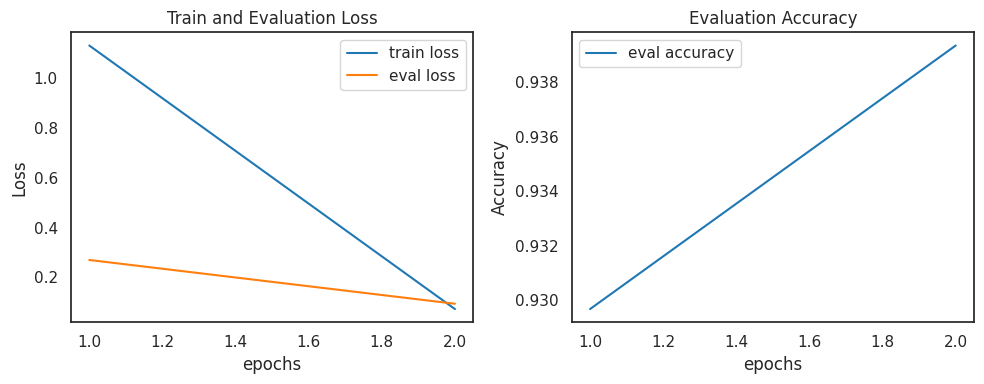

In [42]:
plot_train_history(history)

In [43]:
set_seed(123)

# Get student DataLoader
distil_eval_loader, _ = create_dataloaders(dataset=eval_set,
                                           batch_size=32,
                                           student_collate_fn=distil_collate_fn,
                                           shuffle=False)

# Creating the benchmark for the distilled model
benchmark3 = PerformanceBenchmark(distilbert_tokenizer,
                                  distil_model,
                                  distil_eval_loader,
                                  "distilbert-kd") # KD = 'Knowledge Distillation'

# Add new benchmark to all_benchmarks list
all_benchmarks.append(benchmark3)

# Comparing benchmarks
PerformanceBenchmark.compare_benchmarks(*all_benchmarks)

eval:   0%|          | 0/97 [00:00<?, ?it/s]

eval:   0%|          | 0/97 [00:00<?, ?it/s]

eval:   0%|          | 0/97 [00:00<?, ?it/s]

,name,size,mean_latency,std_latency,accuracy
0,bert fine-tune,418.092,9.847,0.2893,0.925
1,distilbert fine-tune,255.854,5.414,0.1963,0.930
2,distilbert-kd,255.854,5.415,0.1368,0.939


## Conclusions

The fine-tuned distilBERT trained using knowledge distillation works fine and has a slightly higher accuracy than the original model. Besides that, the model's latency is almost 2x shorter than the original model. This is what making a model efficient is like.

## Further experiments

If we're not satisfied with the results above we could try a hyperparameter optimization in which we could alter both factors $(\alpha)$ and $(T)$ to adjust the losses' weights and the probability distribution curve when comparing both models.

# Quantization

To further reduce the model's latency, we can apply ***quantization***, which involves converting high-precision numbers, typically 32-bit floating-point numbers, into lower-precision numbers, such as 8-bit integers. This approach takes a high-precision model and represents its numbers in a more compact and efficient format to make it run faster and consume less memory on hardware with limited resources. Checkout this documentation by [[🤗 Huggingface](https://huggingface.co/docs/optimum/concept_guides/quantization)].

Unfortunetelly this approach is not CUDA supported therefore we must run it using conventional CPU checkout this [[thread](https://discuss.pytorch.org/t/does-dynamic-quantization-support-gpu/119231)]. This tutorial is also a great reference to get to know about dynamic quantization [[Tutorial](https://pytorch.org/tutorials/intermediate/dynamic_quantization_bert_tutorial.html)].

In [44]:
from torch.quantization import quantize_dynamic

# Copy the distilled model
distil_model_quantized = deepcopy(distil_model).to("cpu")

# Quantize model
distil_model_quantized = quantize_dynamic(distil_model_quantized,
                                          {nn.Linear}, # Specify the modules to be quantized
                                          dtype=torch.qint8) # Specify the precision

In [45]:
benchmark4 = PerformanceBenchmark(distilbert_tokenizer,
                                  distil_model_quantized,
                                  distil_eval_loader,
                                  "distilbert-kd-quantized", 
                                  device="cpu")

# Add new benchmark to all_benchmarks list
all_benchmarks.append(benchmark4)

In [46]:
# Setting all benchmarks to 'cpu' for a just comparisson
for bench in all_benchmarks:
    bench.device = "cpu"

PerformanceBenchmark.compare_benchmarks(*all_benchmarks)

eval:   0%|          | 0/97 [00:00<?, ?it/s]

eval:   0%|          | 0/97 [00:00<?, ?it/s]

eval:   0%|          | 0/97 [00:00<?, ?it/s]

eval:   0%|          | 0/97 [00:00<?, ?it/s]

,name,size,mean_latency,std_latency,accuracy
0,bert fine-tune,418.092,76.589,3.1023,0.925
1,distilbert fine-tune,255.854,38.982,1.1198,0.930
2,distilbert-kd,255.854,38.406,0.8771,0.939
3,distilbert-kd-quantized,91.000,12.793,0.6983,0.934
